# Lab session 9: Data Mining Applications

## Introduction 

The aim of this lab is for students to get experience with data mining applications, in particular on **Text Mining** and **Timeseries Mining** methods covered in week 10.

- This lab is the second part of a **two-week assignment** that covers weeks 9 and 10.
- This lab corresponds to **Assignment 4** which is due on **Tuesday 8th December at 10am**, accounting for 10% of your overall grade. Questions in this lab sheet will contribute to 5% of your overall grade; questions in the lab sheet for week 9 will cover for another 5% of your overall grade.
- <font color = 'maroon'>The last section of this notebook includes the questions that are assessed towards your final grade.</font> 

## Important notes about the assignment: 

- **PLAGIARISM** <ins>is an irreversible non-negotiable failure in the course</ins> (if in doubt of what constitutes plagiarism, ask!). 
- The total assessed coursework is worth 40% of your final grade.
- There will be 9 lab sessions and 4 assignments.
- One assignment will cover 2 consecutive lab sessions and will be worth 10 marks (percentages of your final grade).
- The submission cut-off date will be 7 days after the deadline and penalties will be applied for late submissions in accordance with the School policy on late submissions.
- You are asked to submit a **report** that should answer the questions specified in the last section of this notebook. The report should be in **PDF format** (so **NOT** *doc, docx, notebook* etc). It should be well identified with your name, student number, assignment number (for instance, Assignment 4), module, and marked with question numbers. 
- No other means of submission other than submitting your assignment through the appropriate QM+ link are acceptable at any time. Submissions sent via email will **not** be considered.
- Please name your report as follows: Assignment4-StudentName-StudentNumber.pdf
- Cases of **Extenuating Circumstances (ECs)** have to go through the proper procedure of the School in due time. Only cases approved by the School in due time can be considered.

## 1. Text Mining

This first section on text mining will demonstrate a simple method for clustering documents using k-means. As our dataset, we will use articles mined from Wikipedia.

Using python's [wikipedia package](https://pypi.org/project/wikipedia/), we can easily download content from Wikipedia and store it as a python object. For this example, we will use the content of the wikipedia entries that corredpond to the following terms:

    Data Science
    Artificial intelligence
    Bank
    Financial technology
    Basketball
    Swimming
    Tennis

The content of each Wikipedia article is stored in list 'wiki_list' while the title of each article will be stored in variable 'title'.

In [ ]:
# Install/upgrade wikipedia and statsmodels packages for the lab
# !pip install wikipedia
# !pip install statsmodels --upgrade

In [1]:
import pandas as pd
import wikipedia

articles=['Data Science','Artificial intelligence','Bank','Financial technology','Basketball','Swimming','Tennis']
wiki_lst=[]
title=[]

# Load wikipedia articles
for article in articles:
   print("loading content: ",article)
   wiki_lst.append(wikipedia.page(article).content)
   title.append(article)

loading content:  Data Science
loading content:  Artificial intelligence
loading content:  Bank
loading content:  Financial technology
loading content:  Basketball
loading content:  Swimming
loading content:  Tennis


As an example, we can display the first retrieved entry, which was for field "Data Science":

In [ ]:
# Printing the first retrieved entry
print(wiki_lst[0])

Since we are going to use the k-means clustering algorithm, we need to first represent each article using a vector space representation mentioned in the lectures. 

One popular vector space representation used in document clustering and other natural language processing tasks is the so-called **term-frequency/inverse-document-frequency (tf-idf)**. With this representation, for each word $w$ and document $d$ we calculate:

Term frequency $\mathit{tf}(w,d)$: the ratio of the number of appearances of word $w$ in document $d$ divided with the total number of words in document $d$.

Inverse document frequency $\mathit{idf}(w)$: the logarithm of the fraction of the total number of documents divided by the number of documents that contain word $w$.

The tf-idf feature is then defined as:
\begin{equation}
\mathit{tfidf}(w,d)=\mathit{tf}(w,d) \cdot \mathit{idf}(w)
\end{equation}

For computing the above feature, it is recommended that stop words are excluded. All the calculations are easily done with sklearn’s [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html):

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words={'english'})
X = vectorizer.fit_transform(wiki_lst) # Create tf-idf feature of the wikipedia dataset

print(X.shape) # Print dimensions of tf-idf feature

(7, 6789)


As can be seen, each row of variable X is a feature representation of a Wikipedia article.

Now we have converted our dataset in a representation suitable for clustering and other data mining operations, and X can be used as input for the k-means algorithm.

One issue with the k-means algorithm is that the user needs to specify the number of clusters. One way of estimating an appropriate number of clusters is using the so-called elbow method, which calculates the sum of squared distances for various values of k (here we will use values of k from 2 to 7).

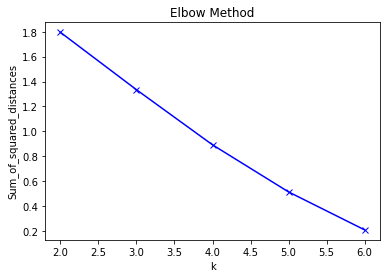

In [4]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(2,7)

for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method')
plt.show()

The plot is almost a straight line, probably because we have too few articles. But at a closer examination a small dent appears for k=4. We will therefore try to cluster into 4 groups.

In [5]:
# Fit k-means model with k=4
true_k = 4
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(X)

# Print list of documents and associated clusters
labels=model.labels_
wiki_cl=pd.DataFrame(list(zip(title,labels)),columns=['title','cluster'])
print(wiki_cl.sort_values(by=['cluster']))

                     title  cluster
4               Basketball        0
6                   Tennis        0
0             Data Science        1
1  Artificial intelligence        2
2                     Bank        2
3     Financial technology        2
5                 Swimming        3


As we can see, the clustering produced by k-means is not perfect; some decisions are sensible (e.g. Basketball and Tennis are in the same cluster; Bank and Financial Technology are in the same cluster), some less so (e.g. Data Science and AI are not in the same cluster; AI belongs to the same cluster with Bank and Financial Technology). However, with more data, more advanced clustering methods, and more elaborate feature extraction and pre-processing, we might be able to mine useful information from our text data.

## 2. Mining timeseries data - Smoothing


Smoothing is a technique applied to a timeseries to remove the fine-grained variation between time steps. The aim of smoothing is to remove noise and better expose the the underlying processes that generated the timeseries. Moving averages are a simple and common type of smoothing used in timeseries analysis and timeseries forecasting.

Calculating a moving average involves creating a new series where the values comprise the average of raw observations in the original timeseries. A moving average requires that you specify a **window size**. This defines the number of raw observations used to calculate the moving average value. The “moving” part in the moving average refers to the fact that the window defined by its window width is slid along the timeseries to calculate the average values in the new series.

For this lab, we will be looking at a particular case of moving average smoothing, called the **Trailing Moving Average**. In trailing moving average smoothing, the value at time $t$ is calculated as the average of the raw observations at and before time $t$.

It should be noted that calculating a moving average of a timeseries makes some assumptions about your data. One of these assumptions is that our timeseries is stationary, or does not show obvious trends (such as long-term increasing or decreasing movements) or seasonality (consistent periodic structure).

For this section, we will be using a dataset that describes the number of daily female births in California in 1959. The dataset units are a count and there are 365 observations corresponding to days in 1959. This dataset is a good example for exploring the moving average method as it does not show any clear trend or seasonality.

First we load and plot the dataset:

            Births
Date              
1959-01-01      35
1959-01-02      32
1959-01-03      30
1959-01-04      31
1959-01-05      44


<AxesSubplot:xlabel='Date'>

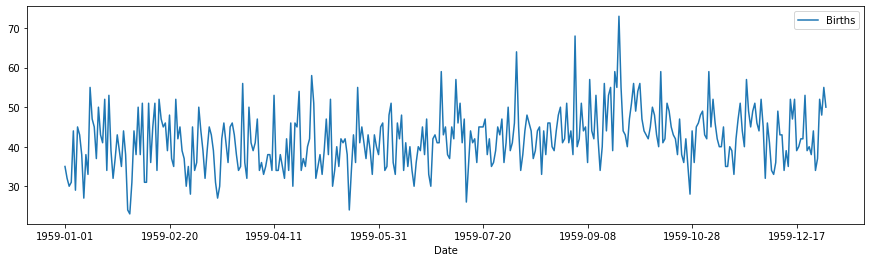

In [6]:
from pandas import read_csv
import matplotlib.pyplot as plt

series = read_csv('births.csv', header=0, index_col=0)

print(series.head())
series.plot(figsize=(15,4))

Moving average can be used as a data preparation technique to create a smoothed version of the original dataset.

The rolling() found in Pandas will automatically group observations into a window. We can specify the window size, and by default a trailing window is created. Once the window is created, we can take the mean value, and this is our transformed dataset. New observations in the future can be just as easily transformed by keeping the raw values for the last few observations and updating a new average value.

To make this concrete, using trailing moving average with a window size of 3, the transformed value at time $t$ is calculated as the mean value for the previous 3 observations $\{t-2, t-1, t\}$.

               Births
Date                 
1959-01-01        NaN
1959-01-02        NaN
1959-01-03  32.333333
1959-01-04  31.000000
1959-01-05  35.000000
1959-01-06  34.666667
1959-01-07  39.333333
1959-01-08  39.000000
1959-01-09  42.000000
1959-01-10  36.000000


<AxesSubplot:title={'center':'smoothed timeseries'}, xlabel='Date'>

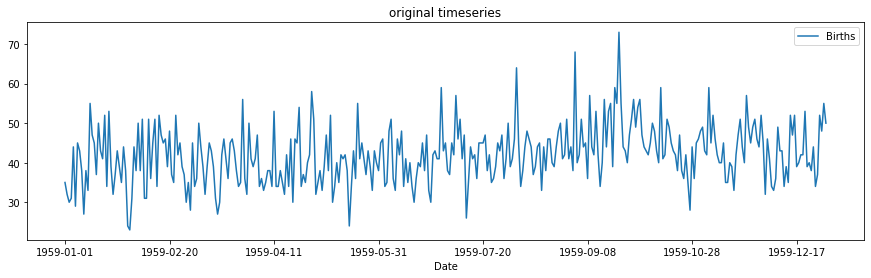

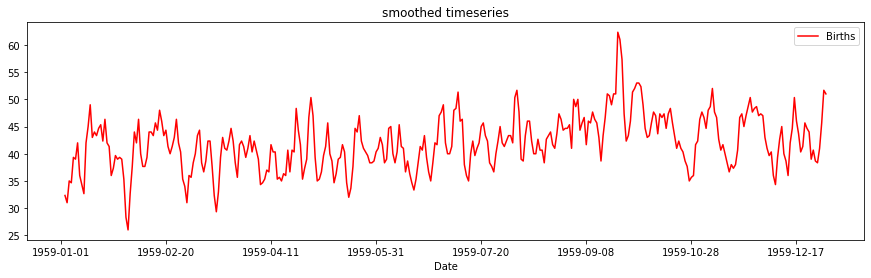

In [7]:
# Perform trailing moving average smoothing
rolling = series.rolling(window=3) # using a window of 3 samples: t, t-1, t-2
rolling_mean = rolling.mean()
print(rolling_mean.head(10))

# plot original and transformed dataset
series.plot(figsize=(15,4),title='original timeseries')
rolling_mean.plot(color='red', figsize=(15,4),title='smoothed timeseries')

From the printed first few values of the smoothed dataset, we can see that the first 2 smoothed observations will need to be discarded.

Please go through the pandas documentation for the Pandas [rolling() function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.rolling.html) as to understand its input arguments and expected output. Following this, you can experiment with different window sizes and study the effect that different window sizes have on smoothing.

## 3. Mining timeseries data - Forecasting

Timeseries data is common in many domains, such as sensor networking, healthcare, and financial markets. In particular, **forecasting** is an important problem in timeseries analysis because it can be used to make predictions about data points in the future.

Altohugh state-of-the-art methods for timeseries forecasting rely on machine learning methods, before exploring such methods it is a good idea to exhaust "classical" linear methods for timeseries forecaseing. Classical time series forecasting methods are focused on exploring linear relationships from timeseries data, and perform well on a wide range of problems, assuming that our data is suitably prepared and the method is well configured. This section will outline a series of classical methods for timeseries forecasting.

### 3.1 Autoregressive (AR) Models

As a first step, we will create a simple synthetic signal which we will use as our dataset. The signal is a simple linear function consisting of 100 samples, which is perturbed by random noise:

Text(0, 0.5, 'Sample value')

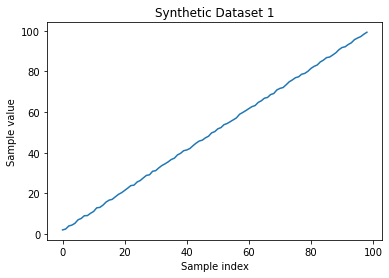

In [8]:
# Initialise
from random import random
import numpy as np

# Create and plot a synthetic signal
data = [x + random() for x in range(1, 100)]

data_array = np.array(data)

plt.plot(data_array)
plt.title('Synthetic Dataset 1')
plt.xlabel('Sample index')
plt.ylabel('Sample value')

**Autoregression (AR)** is a timeseries modeling and forecasting method which models the next step in a sequence as a linear function of the observations at previous time steps. This method is suitable for univariate timeseries without trend and seasonal components.

The notation for the model involves specifying the order of the model $p$ as a parameter to the AR function, e.g. AR(p). For example, AR(1) is a first-order autoregressive model, which uses information from the immediately previous value of the signal to make a prediction for the next value.

More generally, for a signal $y$, an AR model defines the value $y_t$ (where $t$ is the time index) as a linear combination of the previous values of $y$ as follows:
\begin{equation}
y_t = \sum_{i=1}^{p} \alpha_i \cdot y_{t-i} + c + \epsilon_t
\end{equation}
where $p$ defines the model order, coefficients $\alpha_i$ and $c$ are learned from training data, and $\epsilon_t$ values are assumed to be white noise error terms that are uncorrelated with one another.

We can now initialise, fit, and make a prediction for an AR model in order to predict the next value in the timeseries:

In [41]:
# Initialise
from statsmodels.tsa.ar_model import AutoReg

# Fit Autoregressive model
model = AutoReg(data, lags=1, old_names=False) # "lags" indicates the model order
model_fit = model.fit()

# Make prediction
yhat = model_fit.predict(len(data), len(data)+3) # arguments denote which dataset indices to predict
print(yhat)

NameError: name 'data' is not defined

There are many more input arguments that we can use in the AutoReg function; for more information on input/output arguments please view the relevant [AutoReg function documentation](https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AutoReg.html).

### 3.2 Moving Average (MA) Models

While autoregression is a useful predictive property of a timeseries, it does not always explain all the variations. In fact, the unexpected component of the variations (shocks), does impact future values of the timeseries. This component can be captured with the use of a **moving average model (MA)**. The moving average model predicts subsequent series values on the basis of the past history of deviations from predicted values. A deviation from a predicted value can be viewed as white noise, or a shock.

The moving average model is defined as follows:
\begin{equation}
y_t = \sum_{i=1}^{q} b_i \cdot \epsilon_{t-i} + c + \epsilon_t
\end{equation}
Here, $c$ is the mean of the timeseries. The values $b_1,\ldots,b_q$ are the coefficients that need to be learned from the data. The moving average model is quite different from the autoregressive model, in that it relates the current value to the mean of the series and the previous history of deviations from forecasts, rather than the actual values. Here the values of $\epsilon_t$ are assumed to be white noise error terms that are uncorrelated with one another.

We can now initialise, fit, and make a prediction for an MA model in order to predict the next value in the timeseries:

In [10]:
# Initialise
from statsmodels.tsa.arima.model import ARIMA
from random import random

# Fit MA model
model = ARIMA(data, order=(0, 0, 3)) # The 3rd 'order' argument denotes q=3, ie. a 1st order MA model
model_fit = model.fit()

# Make prediction
yhat = model_fit.predict(len(data), len(data)+3) # arguments denote which dataset indices to predict
print(yhat)

C:\Users\heerd\anaconda3\envs\ecs766dm\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[88.18158237 69.40640232 54.23102496 50.39097484]


C:\Users\heerd\anaconda3\envs\ecs766dm\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


As can be seen from the above ARIMA() function, this is a more general function that goes beyond an MA model. By setting the first two arguments for 'order' to 0, we can achieve an MA function. There are many more input arguments that we can use in the ARIMA function; for more information on input/output arguments please view the relevant [ARIMA function documentation](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html).

### 3.3 Autoregressive Moving Average (ARMA) Models

A more general model may be obtained by combining the power of both the autoregressive model and the moving average model. The idea is to learn the appropriate impact of both the autocorrelations and the shocks in predicting timeseries values. The two models can be combined with $p$ autoregressive terms and $q$ moving average terms.

This model is referred to as the ARMA model, which can be formulated as follows:
\begin{equation}
y_t = \sum_{i=1}^{p} \alpha_i \cdot y_{t-i} + \sum_{i=1}^{q} b_i \cdot \epsilon_{t-i} + c + \epsilon_t
\end{equation}
The aforementioned model is the ARMA($p$, $q$) model.

We will now create a new synthetic dataset of 100 samples which consists of (pseudo)random noise:

Text(0, 0.5, 'Sample value')

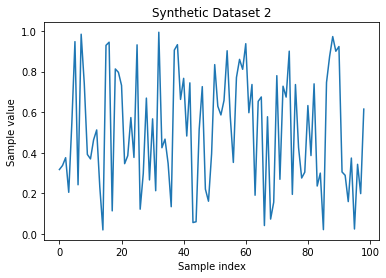

In [11]:
# Create and plot a synthetic signal
data2 = [random() for x in range(1, 100)]

data_array_2 = np.array(data2)

plt.plot(data_array_2)
plt.title('Synthetic Dataset 2')
plt.xlabel('Sample index')
plt.ylabel('Sample value')

We can now initialise, fit, and make a prediction for an ARMA model in order to predict the next value in the timeseries:

In [12]:
# Fit ARMA model
model = ARIMA(data2, order=(2, 0, 1)) # p=2, q=1
model_fit = model.fit()

# Make prediction
yhat = model_fit.predict(len(data2), len(data2)+3) # arguments denote which dataset indices to predict
print(yhat)

[0.50611994 0.51547336 0.51211649 0.51208592]


Similar to the MA model, for the ARMA model we are using the ARIMA() function, which is a more general function that goes beyod an ARMA model. By setting the second argument for 'order' to 0, we can achieve an ARMA function. There are many more input arguments that we can use in the ARIMA function; for more information on input/output arguments please view the relevant [ARIMA function documentation](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html).

### 3.4 Autoregressive Integrated Moving Average (ARIMA) Models

In many cases, nonstationary data can be addressed by combining differencing with the autoregressive moving average model. This results in the **autoregressive integrated moving average model (ARIMA)**. In principle, differences of any order may be used, although first and second-order differences are most commonly used. If the order of the differencing is $d$, then this model is referred to as the ARIMA($p$, $d$, $q$) model.

We will now use the first synthetic dataset of 100 samples to fit and make a prediction using an ARIMA(1,1,1) model:

In [13]:
# Fit ARIMA model
model = ARIMA(data, order=(1, 2, 1)) # p=1, d=2, q=1
model_fit = model.fit()

# Make prediction
yhat = model_fit.predict(len(data), len(data)+3, typ='levels')
print(yhat)

[100.3036699  101.29958182 102.29405982 103.28927129]


## 4. Mining timeseries data - Discrete Fourier Transform (DFT)

The discrete Fourier transform (DFT) is a commonly used method for data transformation in timeseries. More broadly, DFT is one of the fundamental tools used in the field of signal processing and is useful across numerous applications. The DFT is able to decompose a given timeseries into a linear combination of sinusoids.

As an example, let us consider the following example timeseries $x$ which corresponds to a periodic timeseries (specifically a cosine function) perturbed by random noise:

Text(0.5, 0, 'Time (index $n$)')

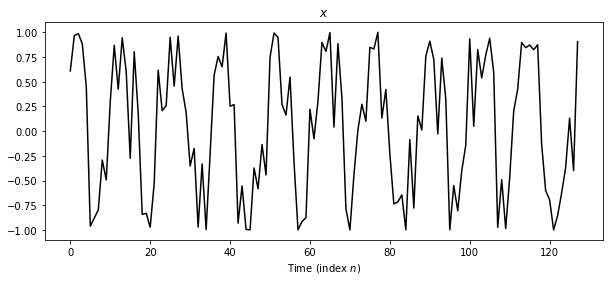

In [14]:
import numpy as np

# Example synthetic timeseries
N = 128
n = np.arange(N)
k = 10
x = np.cos(2 * np.pi * (k * n / N) + 2 * (np.random.rand(N) - 0.5)) 

# Plot
plt.figure(figsize=(10, 4))
plt.title('$x$')
plt.plot(x, 'k')
plt.xlabel('Time (index $n$)')

The DFT is efficiently implemented in python using the **Fast Fourier Transform (FFT)**, an algorithm that computes the discrete Fourier transform in a computationally efficient manner.

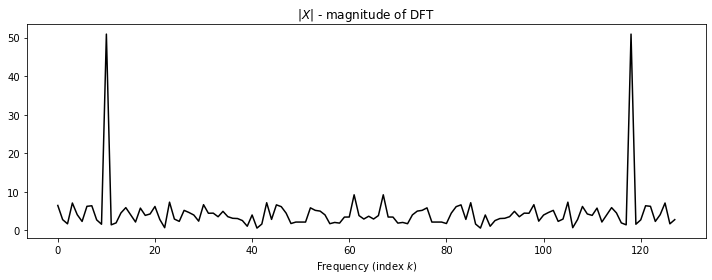

In [27]:
# numpy implementation of FFT
Xfft = np.fft.fft(x)

# Plot
plt.figure(figsize=(10, 4))
plt.title('$|X|$ - magnitude of DFT')
plt.plot(np.abs(Xfft), 'k')
plt.xlabel('Frequency (index $k$)')
plt.tight_layout()

The above figure is symmetric, and the upper half of the above figure can be discarded for analysing the timeseries, but it is useful if we would like to reconstruct the original timeseries. By inspecting the lower half of the DFT, we can see one clear peak. This peak indicates the predominant (i.e. most important) frequency of the timeseries. This frequency indicates the predominant period of the timeseries, in other words the length of the unit in samples which is repeated throughout the timeseries. We observe one such predominant frequency and corresponding period, since the timeseries consists of a (periodic) cosine function.

If we have a timeseries which is expressed in a physical unit (e.g. seconds, milliseconds) it is possible to associate this predominant frequency to a frequency unit such as Hz; this is outside the scope of this lab tutorial.

Finally, one of the benefits of the DFT and FFT is the fact that an inverse transform is also defined, which allows us to convert the above representation over frequency back to the original representation over time. This can be achieved by the **inverse DFT** (and the inverse FFT) as follows:

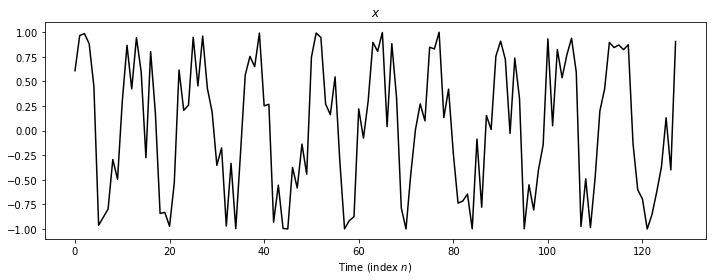

In [16]:
# Inverse FFT
x_invfft = np.fft.ifft(Xfft)

# Plot
plt.figure(figsize=(10, 4))
plt.title('$x$')
plt.plot(x, 'k')
plt.xlabel('Time (index $n$)')
plt.tight_layout()

## <font color = 'maroon'>Assignment</font>

Questions 1-3 are pen-and-paper exercises; questions 4-6 are coding exercises. For all your answers please show your workings (equations or code when applicable).

1. Consider the following sentences related to data mining theory, and assume that each of the above sentences corresponds to a document $d$:
    * Data refers to characteristics that are collected through observation.
    * A dataset can be viewed as a collection of objects.
    * Data objects are described by a number of attributes.
    * An attribute is a characteristic or feature of an object.

  1. Construct and display the document-term matrix for the above documents. Remove all stop words (here consider as stop words: articles, prepositions, conjunctions, pronouns, and common verbs) and punctuation marks; convert any plural nouns/adjectives to their singular form; and convert verbs to the present tense and first person singular form, before you construct the matrix. [1 mark out of 5]
  2. Using the above constructed document-term matrix, calculate the inverse document frequency $\mathit{idf}_i$ for all terms $i$ you have identified from question 1(a). [0.5 marks out of 5]
  
2. Consider a timeseries $y$ were we have obtained values of the timeseries for the following times $t$, as shown in the below table. Using linear interpolation, calculate the values $y$ of the timeseries for times $t = 3$ and $t=5$. [0.5 marks out of 5]

| $t$  | 1  | 4  | 6  |
|-|-|-|-|
| $y$  | 2  | 8  | 5  |

3. Consider the following timeseries $y = \{0.1, 0.15, 0.2, 0.2, 0.3, 0.4, 0.25, 0.6, 0.5\}$. Perform binning on the timeseries using $k=3$ values per bin, and show the resulting timeseries after binning. [0.5 marks out of 5]

## <font color = 'maroon'> Answers to Coding Exercises: </font>

4. Load CSV file "timeseries.csv", which contains a univariate timeseries. Once loaded, convert the timeseries into a numpy array and use the numpy flatten() function to ensure that the loaded timeseries is one-dimensional. Compute the Discrete Fourier Transform (DFT) of the timeseries, and display plots for both the original timeseries and the magnitude of its DFT.

How many predominant frequency components does the timeseries have? [1 mark out of 5]

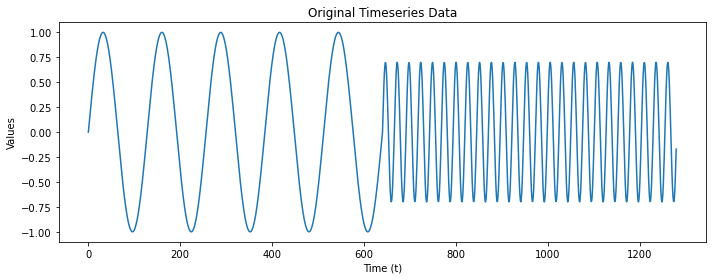

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
from pandas import read_csv

# Load series, convert to numpy then flatten it.
series = read_csv('timeseries.csv', header=None).to_numpy()
series = series.flatten()
# print(series.shape)

# Plot of Original Time Series:
plt.figure(figsize=(10, 4))
plt.title('Original Timeseries Data')
plt.plot(series)
plt.xlabel('Time (t)')
plt.ylabel('Values')
plt.tight_layout()

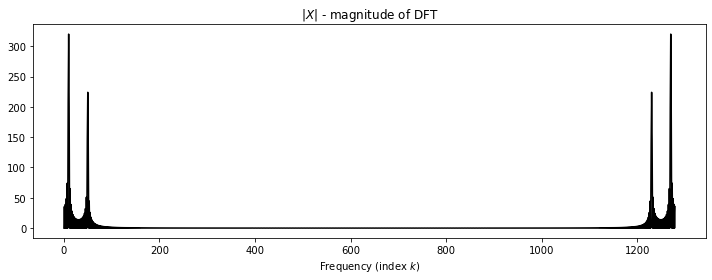

In [16]:
# Compute DFT of timeseries using FFT:
Xfft = np.fft.fft(series)

# Plot of DFT
plt.figure(figsize=(10, 4))
plt.title('$|X|$ - magnitude of DFT')
plt.plot(np.abs(Xfft), 'k')
plt.xlabel('Frequency (index $k$)')
plt.tight_layout()

5. Using the daily births dataset from this lab tutorial, smooth the timeseries using trailing moving average smoothing and a window size that corresponds to one week; then replace any NaN values with zeros.  Perform timeseries forecasting using the smoothed dataset in order to predict daily births for the first 5 days of 1960, using the models below. Show your forecasting results. [0.75 marks out of 5]
    * AR model with $p=2$
    * ARMA model with $p=$ and $q=2$

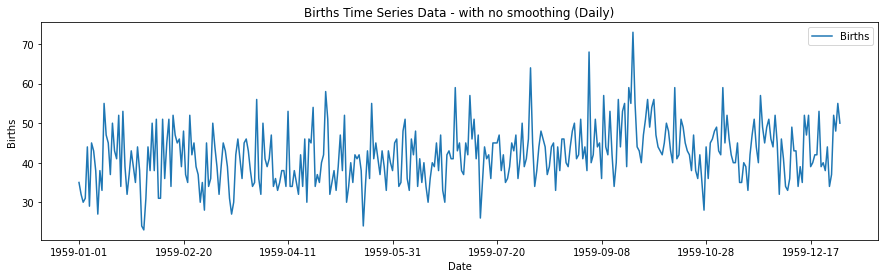

Before NaN removal:
               Births
Date                 
1959-01-01        NaN
1959-01-02        NaN
1959-01-03        NaN
1959-01-04        NaN
1959-01-05        NaN
1959-01-06        NaN
1959-01-07  35.142857
1959-01-08  36.285714
1959-01-09  37.142857
1959-01-10  36.714286

After NaN removal:
               Births
Date                 
1959-01-01   0.000000
1959-01-02   0.000000
1959-01-03   0.000000
1959-01-04   0.000000
1959-01-05   0.000000
1959-01-06   0.000000
1959-01-07  35.142857
1959-01-08  36.285714
1959-01-09  37.142857
1959-01-10  36.714286


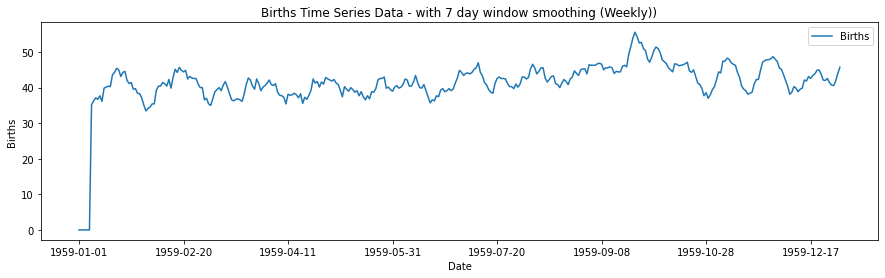

In [36]:
from pandas import read_csv
import matplotlib.pyplot as plt

series = read_csv('births.csv', header=0, index_col=0)
# print(series.head())
series.plot(figsize=(15,4))
plt.xlabel('Date')
plt.ylabel('Births')
plt.title('Births Time Series Data - with no smoothing (Daily)')
plt.show()

# Smooth by trailing moving average smoothing - Window size = 1 week
# Perform trailing moving average smoothing

rolling = series.rolling(window=7) # using a window of weekly samples
print('Before NaN removal:')
print(rolling_mean.head(10))
print()

# Replace NaN with 0.
# print(rolling.fillna(value=0))

rolling_mean = rolling.mean().fillna(0)
print('After NaN removal:')
print(rolling_mean.head(10))


rolling_mean.plot(figsize=(15,4))
plt.xlabel('Date')
plt.ylabel('Births')
plt.title('Births Time Series Data - with 7 day window smoothing (Weekly))')
plt.show()



In [46]:
# Perform timeseries forecasting using the smoothed dataset
# in order to predict daily births for the first 5 days of 1960, using the models below. 

# AR Model p=2:
# Initialise
from statsmodels.tsa.ar_model import AutoReg

# Fit Autoregressive model
model = AutoReg(rolling_mean, lags=2, old_names=False) # "lags" indicates the model order
model_fit = model.fit()

# Make prediction
yhat = model_fit.predict(len(rolling_mean), len(rolling_mean)+4) # arguments denote which dataset indices to predict
print(yhat)

1960-01-01    45.380177
1960-01-02    44.960852
1960-01-03    44.590676
1960-01-04    44.271699
1960-01-05    43.997395
Freq: D, dtype: float64


C:\Users\heerd\anaconda3\envs\ecs766dm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\heerd\anaconda3\envs\ecs766dm\lib\site-packages\statsmodels\tsa\deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,


In [65]:
import warnings
warnings.filterwarnings('ignore')

In [66]:
# Fit ARMA model
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(rolling_mean, order=(2, 0, 2)) # p=2, q=2
model_fit = model.fit()

# Make prediction
yhat = model_fit.predict(len(rolling_mean), len(rolling_mean)+4) # arguments denote which dataset indices to predict
print(yhat)

1960-01-01    45.810247
1960-01-02    45.818766
1960-01-03    45.728092
1960-01-04    45.564016
1960-01-05    45.347305
Freq: D, Name: predicted_mean, dtype: float64


6. Using a similar process used in section 1 of this lab notebook, perform document clustering using k-means on the following wikipedia articles: supervised learning, unsupervised learning, semi-supervised learning, association rule learning, anomaly detection, cluster analysis, dimensionality reduction, regression analysis, statistical classification, data mining, data warehouse, online analytical processing. As with section 1, use the elbow metric to find an appropriate number of clusters. Discuss and display the document clustering results. [0.75 marks out of 5]

In [72]:
import pandas as pd
import wikipedia


articles=['supervised learning', 'unsupervised learning', 'semi-supervised learning', 'association rule learning', 'anomaly detection', 'cluster analysis', 
          'dimensionality reduction', 'regression analysis', 'statistical classification', 'data mining', 'data warehouse', 'online analytical processing']
wiki_lst=[]
title=[]

# Load wikipedia articles
for article in articles:
    print("loading content: ",article)
    wiki_lst.append(wikipedia.page(article).content)
    title.append(article)

loading content:  supervised learning
loading content:  unsupervised learning
loading content:  semi-supervised learning
loading content:  association rule learning
loading content:  anomaly detection
loading content:  cluster analysis
loading content:  dimensionality reduction
loading content:  regression analysis
loading content:  statistical classification
loading content:  data mining
loading content:  data warehouse
loading content:  online analytical processing


In [73]:
# Printing the first retrieved entry
# print(wiki_lst[0])

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words={'english'})
X = vectorizer.fit_transform(wiki_lst) # Create tf-idf feature of the wikipedia dataset

print(X.shape) # Print dimensions of tf-idf feature

(12, 4219)


[4.885926455251841, 4.106571829664187, 3.532296087562986, 2.9076915753219086, 2.504059424387943, 2.0708074084742236, 1.623044290040304, 1.225902299541462, 0.8623317155060548, 0.5234699055386012, 0.2587147332133297]


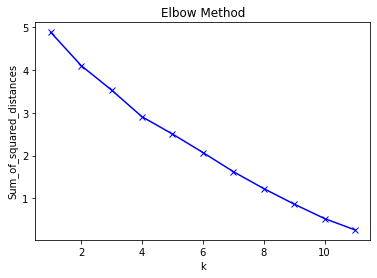

In [75]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1,12)

for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

print(Sum_of_squared_distances)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method')
plt.show()

In [77]:
# Fit k-means model with k=4
true_k = 4
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(X)

# Print list of documents and associated clusters
labels=model.labels_
wiki_cl=pd.DataFrame(list(zip(title,labels)),columns=['title','cluster'])
print(wiki_cl.sort_values(by=['cluster']))

                           title  cluster
9                    data mining        0
10                data warehouse        0
11  online analytical processing        0
5               cluster analysis        1
6       dimensionality reduction        1
8     statistical classification        1
0            supervised learning        2
1          unsupervised learning        2
2       semi-supervised learning        2
3      association rule learning        2
7            regression analysis        2
4              anomaly detection        3
